<a href="https://colab.research.google.com/github/oriol33/TFM_OriolGairin/blob/main/multiv_v1_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM Forecast on CISS series**

In [ ]:
#Import libraries
import math
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from keras.engine.sequential import training_utils
#from sklearn.preprocessing import MinMaxScaler

plt.style.use('fivethirtyeight')

In [ ]:
pip install keras-tuner --upgrade

In [ ]:
import keras_tuner

In [ ]:
#For saving and loading our model
import os 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'drive', 'sample_data']


In [ ]:
# change the OS to use your project folder as the working directory
os.chdir('/content/drive/MyDrive/MESIO/TFM/Models')

In [ ]:
#Comprovation purposes
!touch 'new_file_in_working_directory.txt'

In [ ]:
#Entorno de ejecución
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


**Upload and preparation of the data**

In [ ]:
#Import files from desktop
from google.colab import files
 
files.upload()  

{}

In [ ]:
#Read csv
euro = pd.read_csv('euro.csv', skiprows=5)
uk = pd.read_csv('uk.csv', skiprows=5)
us = pd.read_csv('us.csv', skiprows=5)
china = pd.read_csv('china.csv', skiprows=5)
germany = pd.read_csv('germany.csv', skiprows=5)
italy = pd.read_csv('italy.csv', skiprows=5)
spain = pd.read_csv('spain.csv', skiprows=5)
portugal = pd.read_csv('portugal.csv', skiprows=5)
france = pd.read_csv('france.csv', skiprows=5)

In [ ]:
# Change column names
euro.columns = ['date', 'value', 'status']
uk.columns = ['date', 'value', 'status']
us.columns = ['date', 'value', 'status']
china.columns = ['date', 'value', 'status', 'comment']
germany.columns = ['date', 'value', 'status', 'comment']
italy.columns = ['date', 'value', 'status']
spain.columns = ['date', 'value', 'status']
portugal.columns = ['date', 'value', 'status']
france.columns = ['date', 'value', 'status']

In [ ]:
uk

,date,value,status
0,2022-09-16,0.2753,Normal value (A)
1,2022-09-15,0.2615,Normal value (A)
2,2022-09-14,0.2571,Normal value (A)
3,2022-09-13,0.2375,Normal value (A)
4,2022-09-12,0.2234,Normal value (A)
...,...,...,...
5750,2000-09-07,0.0308,Normal value (A)
5751,2000-09-06,0.0254,Normal value (A)
5752,2000-09-05,0.0269,Normal value (A)
5753,2000-09-04,0.0331,Normal value (A)


In [ ]:
#Reverse data frame (so that first observation is the oldest)
euro = euro.loc[::-1].reset_index(drop=True)
uk = uk.loc[::-1].reset_index(drop=True)
us = us.loc[::-1].reset_index(drop=True)
china = china.loc[::-1].reset_index(drop=True)
germany = germany.loc[::-1].reset_index(drop=True)
italy = italy.loc[::-1].reset_index(drop=True)
spain = spain.loc[::-1].reset_index(drop=True)
portugal = portugal.loc[::-1].reset_index(drop=True)
france = france.loc[::-1].reset_index(drop=True)

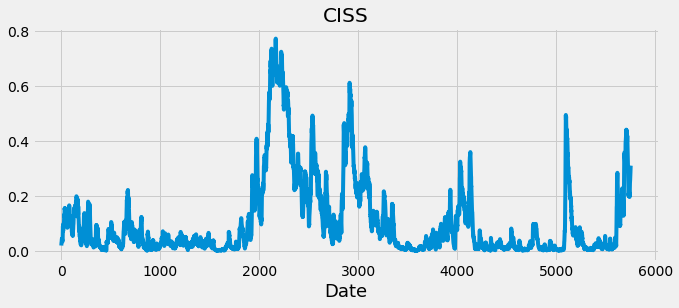

In [ ]:
#Plot
plt.figure(figsize=(10,4))
plt.title("CISS")
plt.plot(france['value'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('', fontsize=18)
plt.show()

In [ ]:
#Select value column
euro = euro.filter(['value'])
uk = uk.filter(['value'])
us = us.filter(['value'])
china = china.filter(['value'])
germany = germany.filter(['value'])
italy = italy.filter(['value'])
spain = spain.filter(['value'])
portugal = portugal.filter(['value'])
france = france.filter(['value'])

#Convert dataframe to numpy
euro = euro.values
uk = uk.values
us = us.values
china = china.values
germany = germany.values
italy = italy.values
spain = spain.values
portugal = portugal.values
france = france.values

In [ ]:
france.shape , china.shape , len(euro)

((5755, 1), (4160, 1), 5755)

In [ ]:
#Partitions for Train + Validation + Test
train_pct = 0.75
valid_pct = 0.15
test_pct = 0.10

training_data_len = math.ceil(len(euro)*train_pct)
valid_data_len = math.ceil(len(euro)*valid_pct)

#training_data_len = 4320
#valid_data_len = 860

In [ ]:
#Create the Train , Validation & Test datasets
train_euro = euro[0:training_data_len-1, :]
train_uk = uk[0:training_data_len-1, :]
train_us = us[0:training_data_len-1, :]
train_germany = germany[0:training_data_len-1, :]
train_italy = italy[0:training_data_len-1, :]
train_spain = spain[0:training_data_len-1, :]
train_portugal = portugal[0:training_data_len-1, :]
train_france = france[0:training_data_len-1, :]

valid_euro = euro[training_data_len:(training_data_len+valid_data_len), :]
valid_uk = uk[training_data_len:(training_data_len+valid_data_len), :]
valid_us = us[training_data_len:(training_data_len+valid_data_len), :]
valid_germany = germany[training_data_len:(training_data_len+valid_data_len), :]
valid_italy = italy[training_data_len:(training_data_len+valid_data_len), :]
valid_spain = spain[training_data_len:(training_data_len+valid_data_len), :]
valid_portugal = portugal[training_data_len:(training_data_len+valid_data_len), :]
valid_france = france[training_data_len:(training_data_len+valid_data_len), :]

test_euro = euro[(training_data_len+valid_data_len): , :]
test_uk = uk[(training_data_len+valid_data_len): , :]
test_us = us[(training_data_len+valid_data_len): , :]
test_germany = germany[(training_data_len+valid_data_len): , :]
test_italy = italy[(training_data_len+valid_data_len): , :]
test_spain = spain[(training_data_len+valid_data_len): , :]
test_portugal = portugal[(training_data_len+valid_data_len): , :]
test_france = france[(training_data_len+valid_data_len): , :]

In [ ]:
print(train_euro.shape ,valid_euro.shape, test_euro.shape)

(4316, 1) (864, 1) (574, 1)


In [ ]:
#Adjust china valid and test datasets to the other countries lengths
train_china = china[0:(len(china)-len(test_euro)-len(valid_euro)), :]
valid_china = china[(len(china)-len(test_euro)-len(valid_euro)):(len(china)-len(test_euro)), :]
test_china = china[(len(china)-len(test_euro)): , :]
print(train_china.shape, valid_china.shape, test_china.shape)

(2722, 1) (864, 1) (574, 1)


In [ ]:
train_df=np.column_stack((train_euro, train_uk, train_us, train_germany, train_italy, train_spain, train_portugal, train_france))

In [ ]:
valid_df=np.column_stack((valid_euro, valid_uk, valid_us, valid_germany, valid_italy, valid_spain, valid_portugal, valid_france))

In [ ]:
test_df=np.column_stack((test_euro, test_uk, test_us, test_germany, test_italy, test_spain, test_portugal, test_france))

In [ ]:
print(train_df[0:10,2], train_us[0:10,0])

[0.0188 0.017  0.0192 0.0246 0.0212 0.0298 0.0367 0.0401 0.037  0.0312] [0.0188 0.017  0.0192 0.0246 0.0212 0.0298 0.0367 0.0401 0.037  0.0312]


In [ ]:
train_df.shape, valid_df.shape, test_df.shape

((4316, 8), (864, 8), (574, 8))

In [ ]:
#Create function to compute trainX and trainY sequences (x: input & y:output).
trainX = []
trainY = []

n_future = 5   # Number of days we want to look into the future based on the past days.
n_past = 64  # Number of past days we want to use to predict the future.

for i in range(n_past, len(train_euro) - n_future +1):
    trainX.append(train_df[i - n_past:i, 0:train_df.shape[1]])
    trainY.append(train_df[i + n_future - 1, 0:train_df.shape[1]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (4248, 64, 8).
trainY shape == (4248, 8).


In [ ]:
#Create function to compute validX and validY sequences (x: input & y:output).
validX = []
validY = []

n_future = 5   # Number of days we want to look into the future based on the past days.
n_past = 64  # Number of past days we want to use to predict the future.

for i in range(n_past, len(valid_euro) - n_future +1):
    validX.append(valid_df[i - n_past:i, 0:valid_df.shape[1]])
    validY.append(valid_df[i + n_future - 1, 0:valid_df.shape[1]])

validX, validY = np.array(validX), np.array(validY)

print('validX shape == {}.'.format(validX.shape))
print('validY shape == {}.'.format(validY.shape))

validX shape == (796, 64, 8).
validY shape == (796, 8).


In [ ]:
#Create function to compute testX and testY sequences (x: input & y:output).
testX = []
testY = []

n_future = 5   # Number of days we want to look into the future based on the past days.
n_past = 64  # Number of past days we want to use to predict the future.

for i in range(n_past, len(test_euro) - n_future +1):
    testX.append(test_df[i - n_past:i, 0:test_df.shape[1]])
    testY.append(test_df[i + n_future - 1, 0:test_df.shape[1]])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (506, 64, 8).
testY shape == (506, 8).


**LSTM network building and training**

Our approach consists on using all train_datasets (from all countries) to train one unique LSTM network that generalizes the properties of the CISS indices. We do so because of the lack of large amounts of data and the need for a data augmentation method to avoid overfitting.

Precisely, we will have 3 LSTM networks, one for each horizon t+h|t of prediction.

**Approach 1:** Concadenate training sequences. Simplest approach (LSTM benchmark). Take batch_size=1 so that internal state is reset for every sequence within the epoch. No hyperparameter tunning optimization technique (just balanced "common sense" choice of hyperparamethers).

**Approach 2:** Concadenate training sequences. The input in the model should be ordered in time. We give the model the ability to remember its internal state during the training sequences within each country. After, we reset its internal state. No hyperparameter tunning optimization technique (just balanced "common sense" choice of hyperparamethers).

**Approach 3:** Bayesian Optimization of the hyperparameter space.

**Approach 4:** Multivariate model, Bayesian Optimization of the hyperparameter space. Stateful??

**Hyperparameters and tunning possibilities**: 

*   Arquitectura del modelo: layers y unidades por layer (Ratio #secuencias/#param. tiene que ser razonable).
*   Sequence length: How many timesteps is our input composed of.
*   Batch_size: number of samples to work through before updating the internal model parameters (number of samples processed before the model is updated).
*   Epochs: number times that the learning algorithm will work through the entire training dataset (the number of complete passes through the training dataset).
*   Optimizer: Adam preferred choice overall. Choice of initial learning rate + reducing learning rate once learning stagnates.
*   Loss function (define loss function)
*   Early stoping (min_delta and patience)
*   Dropout regularization (dropout: Fraction of the units to drop for the linear transformation of the inputs; recurrent_dropout: Fraction of the units to drop for the linear transformation of the recurrent state.)

By default, an LSTM layer in Keras maintains state between data within one batch. ***If*** our tarining data is not ordered in time, ***then*** we might choose batch size=1 (or multiple length of the samples of one country). The nb. of epochs will depend upon when the loss function is stabilized.

By default, the samples within an epoch are shuffled prior to being exposed to the network. ***If*** we want the network to build up state as it learns across the sequence of observations, ***then*** we should disable the shuffling of samples by setting “shuffle” to “False“.

---
**To do list**

(Empty)

---
**Benchmark comparison**
T+1|T (only on germany CISS)

*   Naive approach: 0.000092064151
*   Arma: 0.00007909968
*   Relative Gain: 13.23%






In [ ]:
#Build the LSTM model
#Define a function that creates a hypermodel with a bounded (but not specified) hyperparameter space.
def hypermodel(hp):
  model=Sequential()
  model.add(LSTM(units=hp.Int('units',min_value=2, max_value=8, step=1),
                              dropout=hp.Float('droput',min_value=0.0, max_value=0.20, step=0.05),
                              recurrent_dropout=hp.Float('redroput',min_value=0.0, max_value=0.20, step=0.05),
                              return_sequences=False,
                              input_shape = (trainX.shape[1],trainX.shape[2])))
  model.add(Dense(trainY.shape[1], activation=hp.Choice('dense_activation',values=['sigmoid', 'relu'], default='sigmoid')))
  
  model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
#Bayesian Hyperparameter Optimizer
bayesian_opt_tuner = keras_tuner.BayesianOptimization(
    hypermodel=hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    seed=2020,
    project_name='multiv_t5_v1',
    overwrite=True,)

bayesian_opt_tuner.search(x=trainX ,y=trainY, 
             epochs=25,
             validation_data=(validX, validY),
             batch_size=4,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                              patience=8,
                              min_delta=1e-7,
                              verbose=1,
                              restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.1, 
                                   patience= 3, 
                                   verbose=1, 
                                   min_delta=1e-7, 
                                   mode='min')]
             )

Trial 10 Complete [00h 12m 38s]
val_loss: 0.0023115866351872683

Best val_loss So Far: 0.0009742504335008562
Total elapsed time: 01h 54m 25s


In [ ]:
model = bayesian_opt_tuner.get_best_models(num_models=1)[0]

In [ ]:
#Check
check = model.evaluate(validX, validY, batch_size=4)
print("test loss", check)

199/199 [==============================] - 1s 3ms/step - loss: 9.7425e-04
test loss 0.0009742504335008562


In [ ]:
hyp= bayesian_opt_tuner.get_best_hyperparameters(1)[0]
hyp.values

{'units': 8,
 'droput': 0.0,
 'redroput': 0.0,
 'dense_activation': 'relu',
 'learning_rate': 0.01}

In [ ]:
#hyp= bayesian_opt_tuner.get_best_hyperparameters()[0]
#hyp.get_config()

In [ ]:
#Save the model
model.save("multiv_v1_t5.h5")

**Make best model stateful**

In [ ]:
batch_size = 2

model = Sequential()
model.add(LSTM(8, return_sequences=False, batch_input_shape=(batch_size, trainX.shape[1],trainX.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True))
model.add(Dense(1, activation= 'relu'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (2, 8)                    544       
                                                                 
 dense_1 (Dense)             (2, 1)                    9         
                                                                 
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Choose hyperparameters
batch_size = 2 #batch size
epochs = 60  #epochs (maximum training duration)
loss_f = tf.keras.losses.MeanSquaredError()  #loss function
lr = 0.005 #learning rate
opti = tf.keras.optimizers.Adam(learning_rate=lr)  #optimizer
callback= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=1e-7, verbose=1, restore_best_weights=True),
           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience= 9, verbose=1, min_delta=1e-7, mode='min')]

In [ ]:
#Compile the model
model.compile(optimizer=opti, loss=loss_f, metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
#Define model training and state reset points
def training(nb_epoch):
  for i in range(nb_epoch):
    model.fit(trainX, trainY, batch_size=batch_size, epochs=1, validation_data=(validX, validY), callbacks=callback, shuffle=False)
    model.reset_states()
  return model

In [ ]:
stateful_model = training(nb_epoch=epochs)

2124/2124 [==============================] - 26s 12ms/step - loss: 0.0053 - mean_absolute_error: 0.0514 - val_loss: 0.0213 - val_mean_absolute_error: 0.1331 - lr: 0.0050


**Rebuild and refit**

In [ ]:
model_rebuild=bayesian_opt_tuner.hypermodel.build(hyp)

In [ ]:
callback= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, min_delta=1e-7, verbose=1, restore_best_weights=True),
           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience= 3, verbose=1, min_delta=1e-7, mode='min')]

In [ ]:
np.row_stack((trainX,validX)).shape, np.row_stack((trainY,validY)).shape

((5045, 64, 8), (5045, 8))

In [ ]:
trainvalX = np.row_stack((trainX,validX))
trainvalY= np.row_stack((trainY,validY))

In [ ]:
model_rebuild.fit(trainvalX, trainvalY, epochs=35, batch_size=4, validation_data=(testX, testY), callbacks=callback)

Epoch 1/35
1262/1262 [==============================] - 25s 18ms/step - loss: 0.0024 - val_loss: 0.0022 - lr: 0.0100
Epoch 2/35
1262/1262 [==============================] - 25s 20ms/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0100
Epoch 3/35
1262/1262 [==============================] - 24s 19ms/step - loss: 0.0014 - val_loss: 0.0012 - lr: 0.0100
Epoch 4/35
1262/1262 [==============================] - 27s 22ms/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0100
Epoch 5/35
1262/1262 [==============================] - 27s 22ms/step - loss: 0.0013 - val_loss: 0.0014 - lr: 0.0100
Epoch 6/35
1262/1262 [==============================] - 27s 22ms/step - loss: 0.0013 - val_loss: 0.0016 - lr: 0.0100
Epoch 7/35
1262/1262 [==============================] - ETA: 0s - loss: 0.0013
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1262/1262 [==============================] - 27s 22ms/step - loss: 0.0013 - val_loss: 0.0013 - lr: 0.0100
Epoch 8/35
1262/1262 [===============

In [ ]:
#Save the model
model_rebuild.save("multiv_v1refit_t5.h5")

**Save & load the model**

In [ ]:
#Save the model
#model.save("run3_model_v1_t5_univ.h5")

In [ ]:
#Load the model
model = keras.models.load_model("multiv_v1refit_t5.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
Total params: 616
Trainable params: 616
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Save the model
#model.save('/content/drive/MyDrive/MESIO/TFM/Models')

In [ ]:
#Load the model
#model = keras.models.load_model('/content/drive/MyDrive/MESIO/TFM/Models')
#model.summary()

**Evaluate on test set**

In [ ]:
# Evaluate the model on the test data
results = model.evaluate(testX, testY, batch_size=4)
print("test loss: ", results)

127/127 [==============================] - 1s 4ms/step - loss: 0.0011
test loss:  0.0010852370178326964


**Evaluate by country**

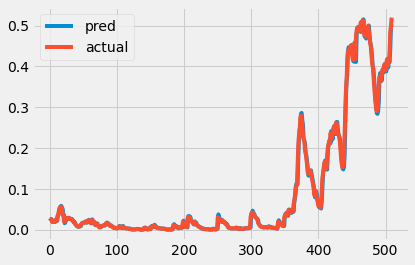

In [ ]:
# Plot the predictions
plt.plot(range(len(pred)), pred, label="pred")
plt.plot(range(len(actual)), actual, label = "actual")
plt.legend()
plt.show()